In [78]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import deque

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import TensorDataset, DataLoader

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

In [79]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [80]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_26600\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_26600\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_26600\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [81]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [82]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [83]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

data = data.dropna()

# BAYES

In [84]:
def plot_model_rmse_and_loss(train): 
    #evaluating train and validation accuracies and losses
    train_loss = train
    #val_loss = val
    #visualizing epochs vs. train and validation accuracies and losses
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs / Training Loss')
    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

In [85]:
features = ['total_aggregated']
total = data[features].values

In [86]:
# Create a DataFrame from the observations
df = pd.DataFrame(total, columns=['total_aggregated'])

# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()

In [162]:
# Define the number of train and test observations
n_train = 35064

# Separate the lags (features) and the observation (target)
#X = df.drop('total_aggregated', axis=1)
X = df['lag_1'].values
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train.reshape(-1,1))

# Use the fitted scaler to transform the test data
X_test_scaled = scaler.transform(X_test.reshape(-1,1))

# Separate the target into training and test sets
y_train, y_test = y[:n_train], y[n_train:]

# Fit the scaler on the training data and transform it
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))

# Use the fitted scaler to transform the test data
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))

In [163]:
X_train, X_test, y_train, y_test = torch.tensor(X_train_scaled).float(), torch.tensor(X_test_scaled).float(), torch.tensor(y_train_scaled).float(), torch.tensor(y_test_scaled).float()

In [170]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(
            BayesianLinear(input_dim, 10, prior_sigma_1=0.01, prior_sigma_2=0.01, prior_pi=1, posterior_mu_init=0),
            nn.ReLU(),
            BayesianLinear(10, 10),
            nn.ReLU(),
            #BayesianLinear(10, 10),
            #nn.ReLU(),
            #BayesianLinear(5, 5),
            #nn.ReLU(),
            BayesianLinear(10, output_dim)
        )

    #self.blinear1 =
    #self.blinear1 =
    #self.blinear3 =    
        
    #def forward(self, x):
    #    x_ = self.blinear1(x)
    #    x_ = F.relu(x_)
    #    x_ = self.blinear2(x)
    #    x_ = F.relu(x_)
    #    return self.blinear3(x_)
    def forward(self, x):
        x_ = self.layer(x)
        return x_

In [171]:
def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 5):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    y_pred = scaler.inverse_transform(means.detach().numpy())

    stds = preds.std(axis=0)

    ci_upper = means + (std_multiplier * stds)
    upper_inv = scaler.inverse_transform(ci_upper.detach().numpy())

    ci_lower = means - (std_multiplier * stds)
    lower_inv = scaler.inverse_transform(ci_lower.detach().numpy())

    y_true = scaler.inverse_transform(y.detach().numpy())

    #ic_acc = (ci_lower < y_vec) == (ci_upper > y_vec)
    #ic_acc = ic_acc.mean()
    return y_pred, y_true, upper_inv, lower_inv, stds # means.float(), ic_acc, (ci_upper >= y).float(), (ci_lower <= y).float(), stds.float()

In [172]:
regressor = BayesianRegressor(1, 1)
optimizer = optim.Adam(regressor.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [174]:
n_train = 24*365
n_forecast_steps = 24  # This could be 1 if you want to predict one step at a time

In [175]:
def train_model(regressor, dataloader, optimizer, criterion, num_epochs=5):
    regressor.train()
    for epoch in range(num_epochs): # TRAINING LOOP FOR PYTORCH. IN THIS CASE 10 TRAINING EPOCHS TO PREDICT PER DAY
        elbo = 0.0
        mse = 0.0
        kl_div = 0.0
        for i, (datapoints, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            loss = regressor.sample_elbo_detailed_loss(inputs=datapoints,                                   # CALCULATION OF THE ELBO USING X (data points) AND Y (labels) OF THE TRAINING SET (OF THE CURRENT WINDOW): 
                                                       labels=labels,                                       # THE "LOSS" ARGUMENT BREAKS DOWN INTO:
                                                       criterion=criterion,                                 # 1. LOSS[1]: ELBO
                                                       sample_nbr=5,                                        # 2. LOSS[2]: MSE
                                                       complexity_cost_weight=1./X_train.shape[0])          # 3. LOSS[3]: KL-DIVERGENCE
            loss[1].backward() #
            optimizer.step()
            elbo += loss[1] #
            mse += loss[2]
            kl_div += loss[3]
        elbo /= len(dataloader) 
        mse /= len(dataloader)
        kl_div /= len(dataloader)       
        print(f"Epoch {epoch+1} - ELBO: {elbo:.6f}, MSE: {mse}, KL DIV: {kl_div}")


In [176]:
n_train = 24*365*3 # SET WINDOW OF 3 YEARS 
n_forecast_steps = 24*7 # SET NUMBER OF STEP AHEAD TO FORECAST 

history_X = X_train
history_y = y_train

predictions = []    # LIST OF FORECASTS
errors = []         # LIST OF RMSE BY DAY
days = 1            # COUNTER OF DAYS
uppers = []         # LIST OF UPPER CONFIDENCE INTERVAL
lowers = []         # AND THE LOWER CONFIDENCE INTERVAL
#deviations = []

for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # STARTING FROM POSITION i OF THE TEST SET I INDICATE UP TO WHICH POSITION THE FORECASTING IS DONE, OR EVERY 24 HOURS/POSITION.OSIZIONI.
                                 # E.G.: IF THE INDEX IS 0 THEN FORECASTING UP TO POSITION 24 (0+24), IF THE INDEX IS 24 UP TO POSITION 48 ETC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # I TAKE THE TEST SET BLOCK ON WHICH TO FORECAST USING THE POSITIONS DECLARED EARLIER
    y_test_block = y_test[i:t_end]

    ds_train = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=168, shuffle=False)

    ds_test = torch.utils.data.TensorDataset(X_test, y_test)
    dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=168, shuffle=True)

    # Train the model
    train_model(regressor, dataloader_train, optimizer, criterion) # FACCIO TRAINING SULLA WINDOW CORRENTE

    y_pred, y_true, ci_upper, ci_lower, stds = evaluate_regression(regressor, X_test_block, y_test_block) # FACCIO FORECASTING DELLE 24 ORE SUCCESSIVE ALLA WINDOW

    predictions.extend(y_pred)
    uppers.extend(ci_upper)
    lowers.extend(ci_lower)
    
    history_X = torch.cat([history_X[24:], X_test_block]) # I UPDATE THE TRAINING SET BY MOVING THE WINDOW FORWARD ONE DAY,  
    history_y = torch.cat([history_y[24:], y_test_block]) # DELETING THE INITIAL 24 HOURS AND ADDING THE 24 HOURS ON WHICH THE FORECAST WAS DONE (NOT THE FORECAST, THE REAL VALUES)

Epoch 1 - ELBO: 0.482370, MSE: 0.4441843032836914, KL DIV: 0.03818519040942192
Epoch 2 - ELBO: 0.162001, MSE: 0.12462019175291061, KL DIV: 0.03738042339682579
Epoch 3 - ELBO: 0.144848, MSE: 0.1102985367178917, KL DIV: 0.03454912081360817
Epoch 4 - ELBO: 0.138091, MSE: 0.10611879825592041, KL DIV: 0.03197266533970833
Epoch 5 - ELBO: 0.129820, MSE: 0.10064384341239929, KL DIV: 0.029176445677876472
Epoch 1 - ELBO: 0.123028, MSE: 0.09604255110025406, KL DIV: 0.026985840871930122
Epoch 2 - ELBO: 0.118664, MSE: 0.09383367002010345, KL DIV: 0.024830713868141174
Epoch 3 - ELBO: 0.116259, MSE: 0.09312861412763596, KL DIV: 0.02313060127198696
Epoch 4 - ELBO: 0.112555, MSE: 0.09077242016792297, KL DIV: 0.02178235724568367
Epoch 5 - ELBO: 0.112869, MSE: 0.092048779129982, KL DIV: 0.02082039602100849
Epoch 1 - ELBO: 0.111145, MSE: 0.09116354584693909, KL DIV: 0.01998133398592472
Epoch 2 - ELBO: 0.109706, MSE: 0.0900878757238388, KL DIV: 0.019618462771177292
Epoch 3 - ELBO: 0.109299, MSE: 0.08999972

In [177]:
y_true = np.array(y[-len(predictions):])
up = np.array(uppers).flatten()
lo = np.array(lowers).flatten()
u_upper = up >= y_true
o_lower = lo <= y_true
total = (u_upper == o_lower)

#
print("{} our predictions are in our confidence interval".format(np.mean(total)))

0.41512767897856817 our predictions are in our confidence interval


In [178]:
truth = []
for i in data[features].values:
    truth.append(float(i))
res = pd.DataFrame()
res['y_true'] = truth[-len(predictions):]
res['y_pred'] = predictions
res['upper_ci_bound'] = up
res['lower_ci_bound'] = lo

In [179]:
rmse = sqrt(np.mean((res.y_pred - res.y_true)**2))
print('Mean Squared Error:', rmse)

Mean Squared Error: 2053.83056750064


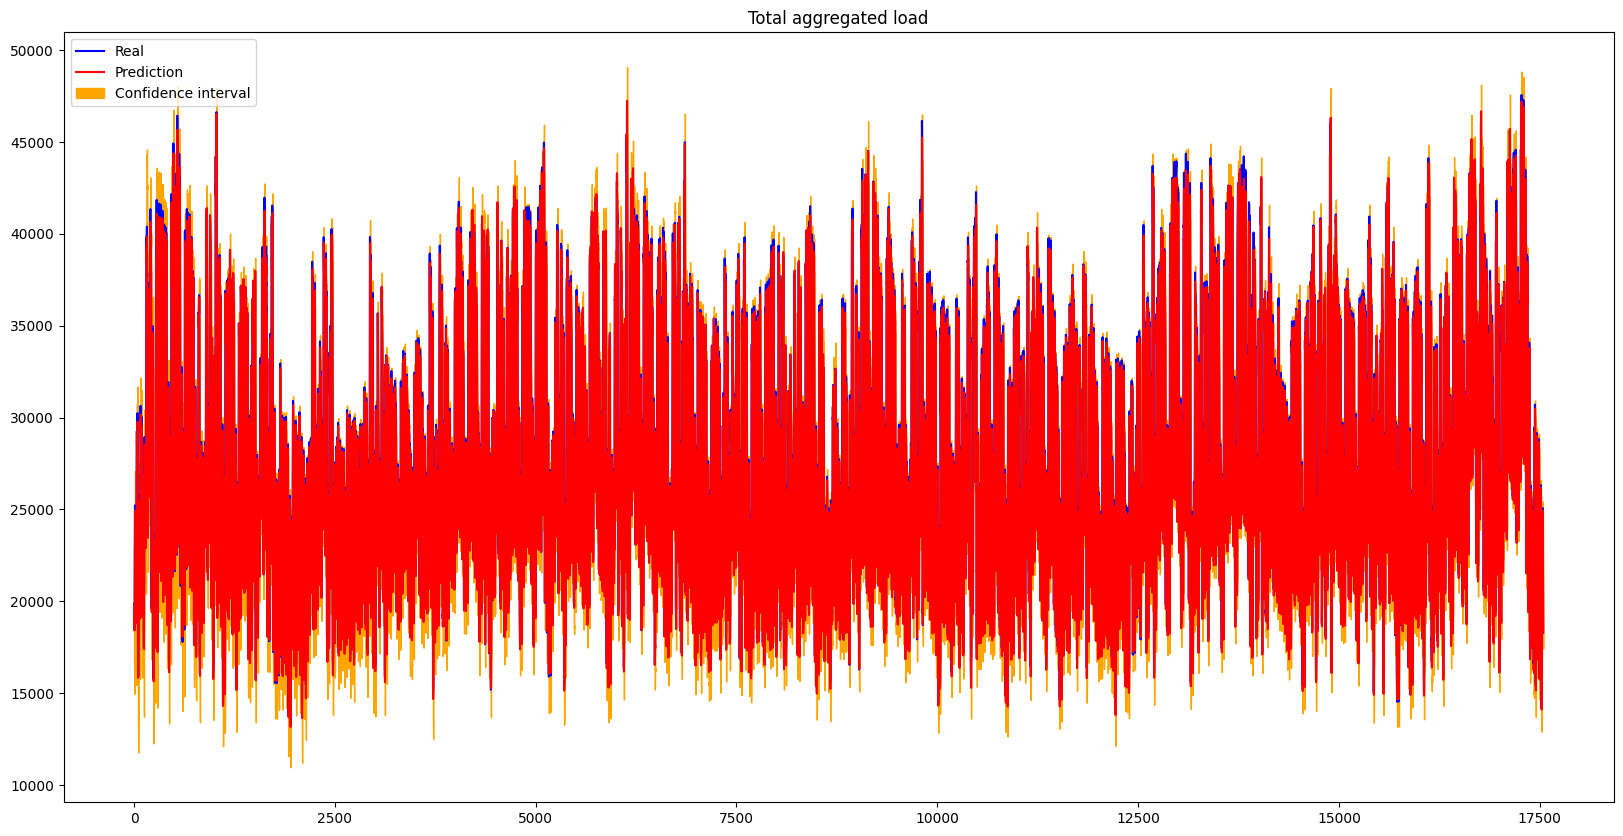

In [180]:
#plot_preds_vs_actual(res.y_true, res.y_pred)
plt.figure(figsize=(20,10))
plt.title("Total aggregated load", color="black")

plt.plot(res.index,
         res.y_true,
         color='Blue',
         label="Real")

plt.plot(res.index,
         res.y_pred,
         label="Prediction",
         color="red")

plt.fill_between(x=res.index,
                 y1=res.upper_ci_bound,
                 y2=res.lower_ci_bound,
                 color='orange',
                 label="Confidence interval",
                 alpha=1)

plt.legend()